In [74]:
from methods_fromhome import *
import geopandas as gpd
from shapely.geometry import LinearRing
from shapely.geometry import LineString

In [75]:
def getExtrapoledLine(p1,p2):
    'Creates a line extrapoled in p1->p2 direction'
    EXTRAPOL_RATIO = 10
    a = p1
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]) )
    return LineString([a,b])

In [84]:
bfe = gpd.read_file('bfe_mre_all.shp')
fsp = gpd.read_file('fsp_sample_mre1.shp')

# Reproject files to UTM
bfe.to_crs(26913, inplace=True)
bfe = bfe[['ELEV', 'geometry']]

fsp.to_crs(26913, inplace=True)
fsp = fsp[['geometry']]
fsp.reset_index(inplace=True)

fl = gpd.read_file('flowline.shp')
fl.to_crs(26913, inplace=True)
fl = fl[['geometry']]
fl.reset_index(inplace=True)

In [96]:
fsp_ext = fsp.geometry.exterior[0]
# Extend BFEs over FSP Poly
bfe_extend = extend_bfe1(bfe, fsp_ext)

# Split FSP Poly by extended BFEs
fsp_s = split_fsp(fsp, bfe_extend)


# Split Flowline by BFEs
fl = split_flowline(fl, bfe)

# Find forks and place in list
forks_ls = find_forks(fl)

# Create Flowline Buffer
fl['buff'] = fl.apply(lambda x: x.geometry.buffer(1))
fl_buff = fl.set_geometry('buff')
fl_buff = fl_buff[['buff']]
fl = fl[['geometry']]

# get fl_segs that are forks
all_fsegs_forks = [segs for e in forks_ls for segs in e]

fl_non_forks = fl.loc[~fl.index.isin(all_fsegs_forks)].reset_index()
fl_buff_non_forks = fl_buff.loc[~fl_buff.index.isin(all_fsegs_forks)].reset_index()


In [77]:
def getExtrapoledLine(p1,p2):
    'Creates a line extrapoled in p1->p2 direction'
    EXTRAPOL_RATIO = 10
    a = p1
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]) )
    return LineString([a,b])

In [78]:
def get_ext_linestring(fr_pt, ba_pt):
    all_coords = []
    pt_group = [fr_pt, ba_pt]

    for l in pt_group:
        if l.geom_type == 'MultiPoint':
            explode = [x for x in l]
            e_coords = [explode[0].coords[0], explode[1].coords[0]]
        
            all_coords.append(e_coords[0])
            all_coords.append(e_coords[1])
        else:
            coords = l.coords[0]
    
            all_coords.append(list(coords))
    nline = LineString(all_coords)

    return nline

In [89]:
# 1: Extend BFES Across FSP POLYGON
def extend_bfe1(bfe, fsp_ext):
    bfe_e = bfe.copy()
    bfe_e['points'] = bfe_e.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
    bfe_e['fr_ext'] = bfe_e.apply(lambda x: getExtrapoledLine(x['points'][0], x['points'][1]), axis=1)
    bfe_e['ba_ext'] = bfe_e.apply(lambda x: getExtrapoledLine(x['points'][1], x['points'][0]), axis=1)

    bfe_e['fr_pt'] = bfe_e.apply(lambda x: fsp_ext.intersection(x['fr_ext']), axis=1)
    bfe_e['ba_pt'] = bfe_e.apply(lambda x: fsp_ext.intersection(x['ba_ext']), axis=1)

    bfe_e['ext_geom'] = bfe_e.apply(lambda x: get_ext_linestring(x['fr_pt'], x['ba_pt']), axis=1)
    bfe_e['ext_geom_scale'] = bfe_e.apply(lambda x: scale(x.geometry, xfact=1.1, yfact=1.1), axis=1)
    
    bfe_e = bfe_e[['ELEV', 'ext_geom_scale']]
    bfe_e.rename(columns={'ext_geom_scale': 'geometry'}, inplace=True)
    bfe_e.set_geometry('geometry', crs=26913, inplace=True)
    
    return bfe_e

In [195]:
bfe_extend = extend_bfe(bfe, fsp_ext)

In [196]:
bfe_extend

,ELEV,geometry
0,630.0,"LINESTRING (1263914.819 3630596.171, 1263922.1..."
1,632.0,"LINESTRING (1263797.884 3630624.557, 1263802.4..."
2,635.0,"LINESTRING (1263457.831 3630733.424, 1263479.9..."
3,635.0,"LINESTRING (1263458.324 3630794.932, 1263433.6..."
4,640.0,"LINESTRING (1263132.456 3630785.489, 1263144.9..."
5,640.0,"LINESTRING (1263359.678 3630920.490, 1263387.4..."
6,642.0,"LINESTRING (1262984.322 3630903.417, 1263000.7..."
7,642.0,"LINESTRING (1263247.745 3631091.304, 1263270.2..."
8,644.0,"LINESTRING (1262906.457 3630968.363, 1262907.9..."
9,648.0,"LINESTRING (1262735.214 3631059.929, 1262761.7..."


In [197]:
bfe_extend.to_file('all_bfes_extend.shp')

In [151]:
bfe_set['points'] = bfe_set.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
bfe_set['fr_ext'] = bfe_set.apply(lambda x: getExtrapoledLine(x['points'][0], x['points'][1]), axis=1)

In [153]:
bfe_set['ba_ext'] = bfe_set.apply(lambda x: getExtrapoledLine(x['points'][1], x['points'][0]), axis=1)

In [156]:
bfe_set['fr_pt'] = bfe_set.apply(lambda x: fsp_ext.intersection(x['fr_ext']), axis=1)
bfe_set['ba_pt'] = bfe_set.apply(lambda x: fsp_ext.intersection(x['ba_ext']), axis=1)

In [169]:
bfe_set['ext_geom'] = bfe_set.apply(lambda x: get_ext_linestring(x['fr_pt'], x['ba_pt']), axis=1)

[[1263000.0022201056, 3630923.8042457947], [1262985.057878385, 3630904.3734977194]]
[(1262907.8800405634, 3631005.6455810876), (1262906.5258761572, 3630970.1792287678), [1262906.5258761572, 3630970.1792287678]]


In [174]:
bfe_set_ext = bfe_set.set_geometry('ext_geom', crs=26913)

In [175]:
bfe_set_ext = bfe_set_ext[['ELEV', 'ext_geom']]
bfe_set_ext.to_file('bfe_set_ext.shp')

In [96]:
bfe = bfe_set.iloc[1]
coords = list(bfe.geometry.coords)
fr = getExtrapoledLine(coords[0], coords[1])
ba = getExtrapoledLine(coords[1], coords[0])
g(fr, 26913).to_file('fr.shp')
g(ba, 26913).to_file('ba.shp')
print('fr', fr)
print('ba', ba)
#print(bfe.geometry.boundary.geoms[0].coords[0])
print(l_coords)

fr LINESTRING (1262906.5242718155 3630970.1372101256, 1262920.074466024 3631325.0246666376)
ba LINESTRING (1262907.8792912364 3631005.625955777, 1262894.329097028 3630650.7384992647)
[(1262985.0677890843, 3630904.3863836867), (1262999.9862148121, 3630923.783435589)]


In [114]:
pt_explode = [p for p in fr_pt]
for p in pt_explode:
    print(p.coords[0])

(1262907.8800405634, 3631005.6455810876)
(1262906.5258761572, 3630970.1792287678)


In [113]:
pt_explode[0].coords

In [124]:
all_coords = e_coords + [coords]
nline = LineString(all_coords)
g(nline, 26913).to_file('nline_5.shp')

In [127]:
nline = g(nline, 26913)

In [135]:
nline_scaled = nline.geometry.scale(xfact=1.1, yfact=1.1)
g(nline_scaled, 26913).to_file('nline_scaled11.shp')

In [136]:
nline_scaled = g(nline_scaled, 26913)
fsp_s = split_fsp(fsp, nline_scaled)
fsp_s.explore()

In [103]:
fr_pt = fsp_ext.intersection(fr)
ba_pt = fsp_ext.intersection(ba)
pt_group = [fr_pt, ba_pt]

for l in pt_group:
    if l.geom_type == 'MultiPoint':
        explode = [x for x in l]
        e_coords = [explode[0].coords[0], explode[1].coords[0]]
    else:
        coords = l.coords[0]
            
            nline = LineString([explode[0].coords[0], explode[1].coords[0]])


try:
    nline = LineString([fr_pt.coords[0], ba_pt.coords[0]])
    g(nline, 26913).to_file('nline_3.shp')
except:
    pts = [fr_pt, ba_pt]
    for p in pts:
        if p.geom_type != 'Point':
            p_coords = (p.geoms[0].coords, p.geoms[1].coords)

    nline = LineString([p_coords[0], p_coords[1], ])
    g(nline, 26913).to_file('nline_3.shp')
    


POINT (1262907.8800405634 3631005.6455810876)


AssertionError: 

In [65]:
def ext_line_intersect(xline, fsp_ring, list):
    pts = fsp_ring.intersection(xline)
    if pts.geom_type == 'MultiPoint':
        list.append(pts.geoms[0].coords[0])
        list.append(pts.geoms[1].coords[0])
    else:
        npts = pts.coords[0]
        list.append(npts)

    
    return list

In [66]:
fsp_ext = fsp.geometry.exterior[0]
bfe_set_snap = gpd.GeoDataFrame()
for i, geom in bfe_set.iterrows():
    l_coords = list(geom.geometry.coords)
    ext_end = getExtrapoledLine(*l_coords[-2:])
    ext_start = getExtrapoledLine(*l_coords[:2])
    ext_ls = [ext_end, ext_start]
    
    for e in ext_ls:
        l_coords = ext_line_intersect(e, fsp_ext, l_coords)

    nline = g(LineString(l_coords), 26913)
    bfe_set_snap = pd.concat([bfe_set_snap, nline], ignore_index=True)
        

In [67]:
bfe_set_snap.to_file('bfe_set_snap2.shp')

In [22]:
l_coords = list(bfe.geometry.coords)

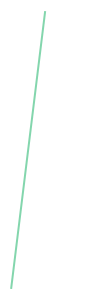

In [26]:
ext_line = getExtrapoledLine(*l_coords[-2:])
ext_line

In [27]:
df = g(ext_line, 26913)
df.to_file('ext_line.shp')

In [28]:
if fsp_ext.intersects(ext_line):
    pts = fsp_ext.intersection(ext_line)
    npts = list(pts.coords)[0]
else:
    print('Problem')

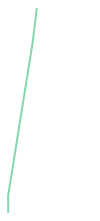

In [29]:
l_coords.append(npts)
nline = LineString(l_coords)
nline

In [30]:
ndf = g(nline, 26913)
ndf.to_file('new_line.shp')